**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/TBS.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date       Open       High        Low      Close  Volume  \
0 1999-01-01  3713.4357  3841.4852  3713.4357  3713.4357       0   
1 1999-01-04  3713.4357  3841.4852  3713.4357  3841.4852   35293   
2 1999-01-05  3841.4852  3841.4852  3809.4729  3809.4729   25694   
3 1999-01-06  3809.4729  3841.4852  3809.4729  3835.0828  209500   
4 1999-01-07  3835.0828  3841.4852  3803.0704  3803.0704  136616   

   Earnings Yield (EY)  Dividend Yield (DY)  P:E Ratio (P:E) Trades  \
0                10.92                 3.93         9.157509      -   
1                10.53                 3.81         9.496676      -   
2                10.66                 3.81         9.380863      -   
3                10.53                 3.81         9.496676      -   
4                10.66                 3.81         9.380863      -   

  Trade Value  Total Return Index (TRI)  
0           -                130.440415  
1           -                134.938360  
2           -                133.813876  
3           -                134.713465  
4           -                133.588978

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11  0.000000  0.036082 -0.001540 -0.001540  0.006182  0.017094   
2000-05-12 -0.060432  0.015552 -0.001542 -0.003082 -0.003082  0.004640   
2000-05-15 -0.072321  0.000000 -0.004640 -0.006182 -0.007722 -0.007722   
2000-05-16 -0.031253  0.000000  0.007722  0.003082  0.001540  0.000000   
2000-05-17 -0.044032  0.000000  0.000000  0.007722  0.003082  0.001540   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11 -0.020108 -0.002244 -0.019644  -0.007121  ...      0.024923   
2000-05-12 -0.001907  0.003688 -0.024078  -0.002999  ...      0.036082   
2000-05-15  0.011000  0.002459 -0.030068  -0.002453  ...      0.012423   
2000-05-16  0.014054  0.001639 -0.026936  -0.002007  ...      0.001549   
2000-05-17  0.010327  0.001093 -0.018667  -0.001642  ...      0.000000   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11     0.039531      0.026461           0.026461          0.048790   
2000-05-12     0.033048      0.000000           0.037622          0.039221   
2000-05-15     0.007782     -0.003082           0.012423          0.012423   
2000-05-16     0.006211     -0.021277           0.009259          0.013921   
2000-05-17     0.000000     -0.025701           0.004605          0.004605   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11            0.039159            0.023384           0.045713   
2000-05-12            0.018634            0.034540           0.036139   
2000-05-15            0.004640            0.007782           0.007782   
2000-05-16            0.001537            0.007722           0.012384   
2000-05-17            0.004605            0.000000           0.000000   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11            0.023384          0.047253  
2000-05-12           -0.003082          0.037681  
2000-05-15           -0.007722          0.012423  
2000-05-16           -0.022815          0.006211  
2000-05-17           -0.030305          0.000000  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.0025878644582419657
  dropout = 0.09925874693114575
  units = 256
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 80
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0006500748736170612
RMSE = 0.02549656591812045
MAE = 0.019549783604513662
R-Squared = 0.23362531656988028

Results on Validation set: 
MSE = 0.000633684826629193
RMSE = 0.025173097279222376
MAE = 0.017562503271306873
R-Squared = -0.02873217722412602

Results on Testing set: 
MSE = 0.0005574483636127534
RMSE = 0.023610344419613058
MAE = 0.01944404848319422
R-Squared = -0.13004932532594138



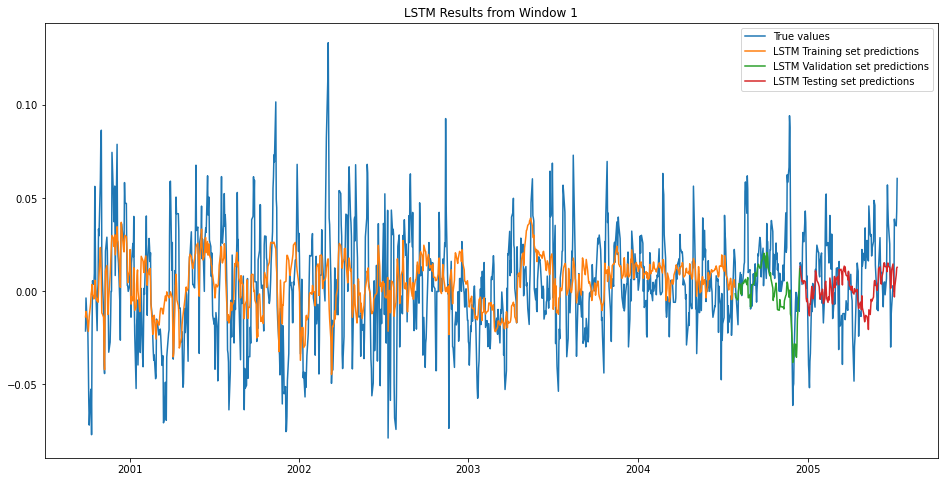

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0002799525779017531
RMSE = 0.01673178346446526
MAE = 0.012330315676065245
R-Squared = 0.6348965991273716

Results on Validation set: 
MSE = 0.0004863060265606635
RMSE = 0.0220523474161066
MAE = 0.01738141625661831
R-Squared = -0.023987102114356063

Results on Testing set: 
MSE = 0.0011722663639923408
RMSE = 0.03423837560387964
MAE = 0.027372785454256487
R-Squared = -0.5504583671716841



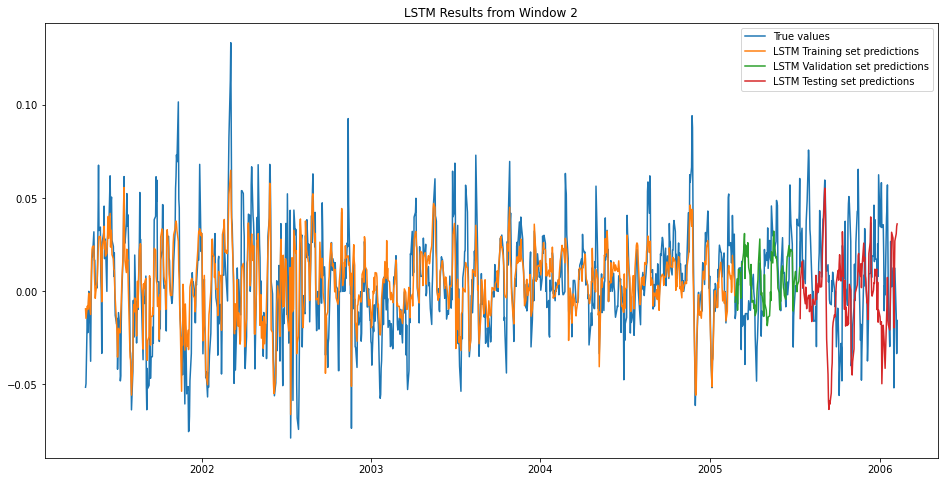

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0006311371870631737
RMSE = 0.025122443891133953
MAE = 0.01903354347825107
R-Squared = 0.0871501796809594

Results on Validation set: 
MSE = 0.0008446872847527527
RMSE = 0.029063504343983585
MAE = 0.023528962897516617
R-Squared = -0.032229220930938274

Results on Testing set: 
MSE = 0.0015499026952801227
RMSE = 0.039368803579485655
MAE = 0.030697400827274884
R-Squared = -0.08439666458921735



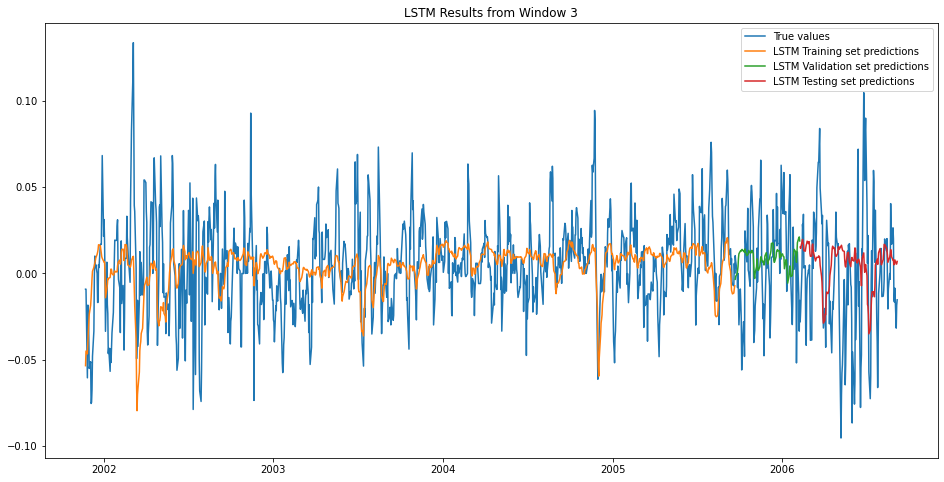

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.00016802565223964422
RMSE = 0.012962470915672066
MAE = 0.00960935442400218
R-Squared = 0.73061655454977

Results on Validation set: 
MSE = 0.0015253057476794772
RMSE = 0.03905516288123092
MAE = 0.029043143934128497
R-Squared = 0.028892529335495132

Results on Testing set: 
MSE = 0.0009879960457758207
RMSE = 0.03143240439062562
MAE = 0.023777184731179832
R-Squared = -0.06507383864803029



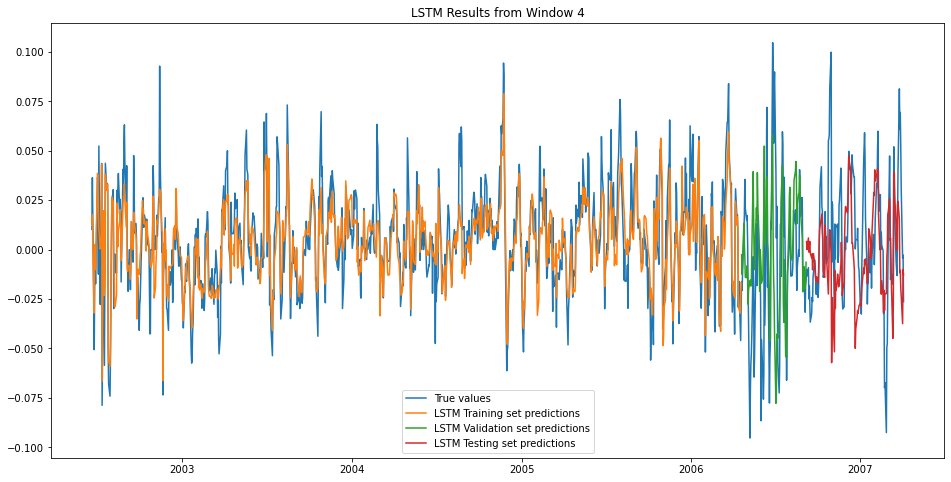

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0005565607884204848
RMSE = 0.02359154061142436
MAE = 0.017638049492527827
R-Squared = 0.216929401014603

Results on Validation set: 
MSE = 0.000930237470582444
RMSE = 0.030499794599020566
MAE = 0.023731806345347932
R-Squared = 0.04274219668614776

Results on Testing set: 
MSE = 0.0009550438635273003
RMSE = 0.03090378396778136
MAE = 0.023539287567854526
R-Squared = -0.011324085847557397



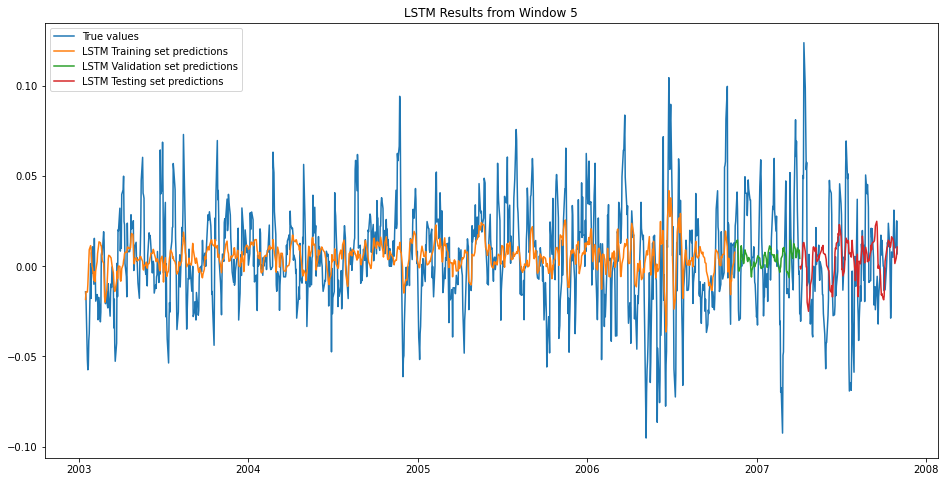

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0006354221424679308
RMSE = 0.02520758105149978
MAE = 0.019132275423361392
R-Squared = 0.18686682762508067

Results on Validation set: 
MSE = 0.0007357058828289303
RMSE = 0.027123898739468306
MAE = 0.01991437972770232
R-Squared = -0.024456513836449645

Results on Testing set: 
MSE = 0.0026134166393396554
RMSE = 0.051121586823372915
MAE = 0.037219870275439056
R-Squared = -0.9902976614306878



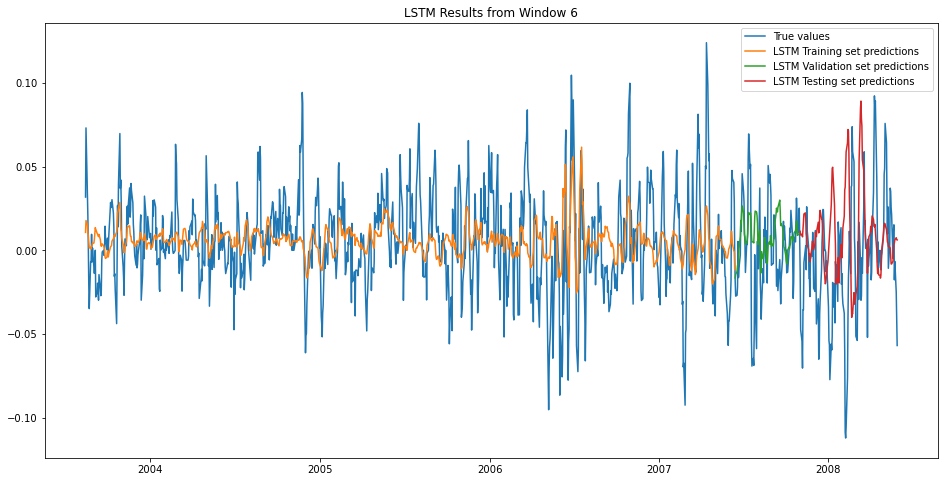

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.00047676676188850486
RMSE = 0.02183498939520019
MAE = 0.01602319034996089
R-Squared = 0.44592666174836426

Results on Validation set: 
MSE = 0.001234096462093745
RMSE = 0.035129709109153535
MAE = 0.026874852464949667
R-Squared = 0.16216050340166555

Results on Testing set: 
MSE = 0.003307177793695438
RMSE = 0.057508067205353355
MAE = 0.04537706812290883
R-Squared = 0.06620817498170017



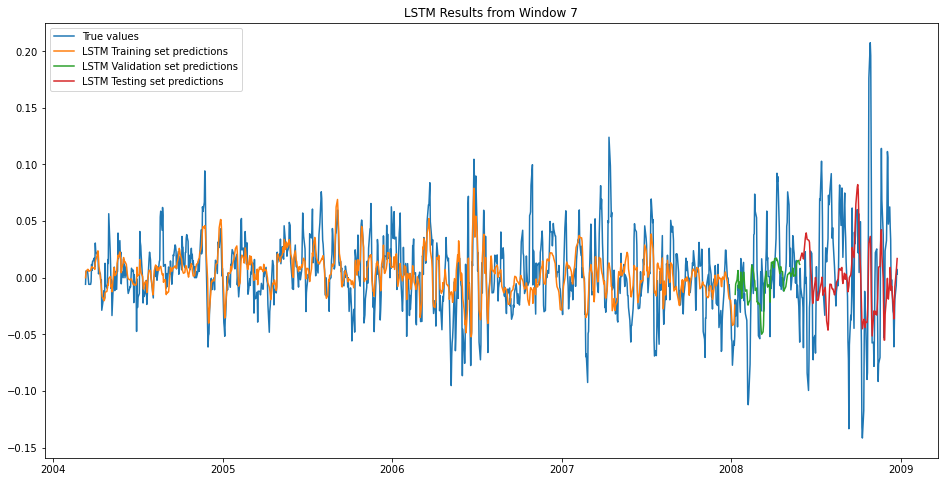

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0005959490861207588
RMSE = 0.024412068452320027
MAE = 0.018355030553826708
R-Squared = 0.44844504356114856

Results on Validation set: 
MSE = 0.003363239811109262
RMSE = 0.05799344627722396
MAE = 0.043438198076532535
R-Squared = 0.1809708392021837

Results on Testing set: 
MSE = 0.0011723102884935743
RMSE = 0.03423901704917322
MAE = 0.025700989827351795
R-Squared = -0.11437558115789659



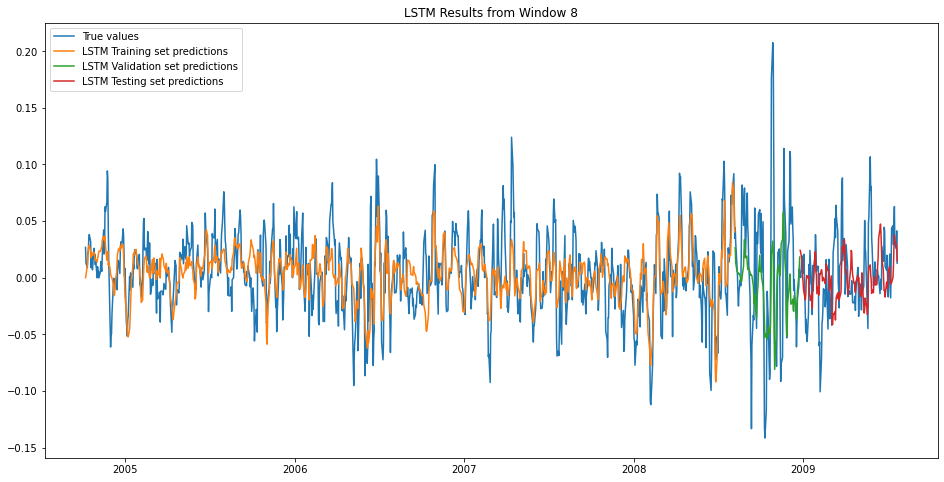

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0012260336513209267
RMSE = 0.03501476333378432
MAE = 0.02625079012519648
R-Squared = 0.15841189943585632

Results on Validation set: 
MSE = 0.0008372409642097722
RMSE = 0.028935116454055824
MAE = 0.022370282157009102
R-Squared = 0.06247859893518559

Results on Testing set: 
MSE = 0.0005641489272921738
RMSE = 0.023751819452247733
MAE = 0.019265256437749533
R-Squared = -0.1809704195232018



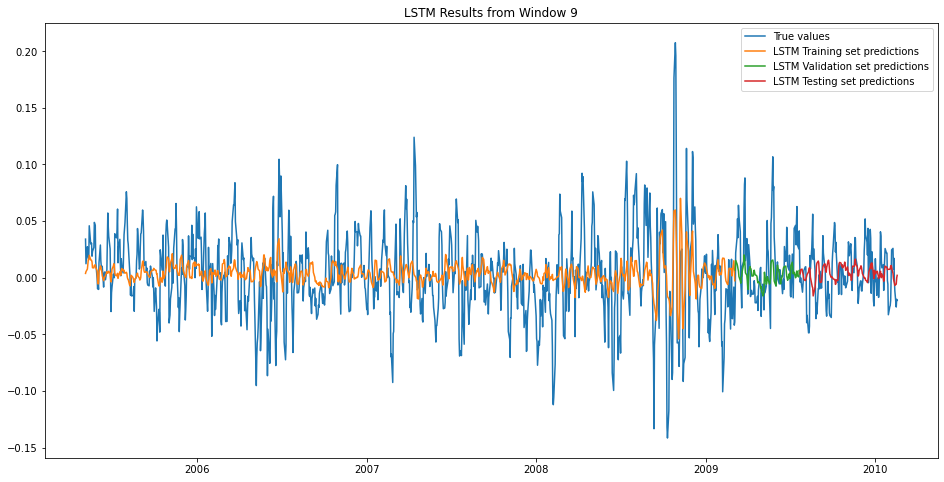

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0012633945750426534
RMSE = 0.035544262195784194
MAE = 0.02672714083281562
R-Squared = 0.1398706555014877

Results on Validation set: 
MSE = 0.00035888685321496254
RMSE = 0.018944309256738883
MAE = 0.01568935646012194
R-Squared = 0.07716392481853618

Results on Testing set: 
MSE = 0.0007507336247364532
RMSE = 0.027399518695343048
MAE = 0.022271573829034504
R-Squared = -0.09966190673984232



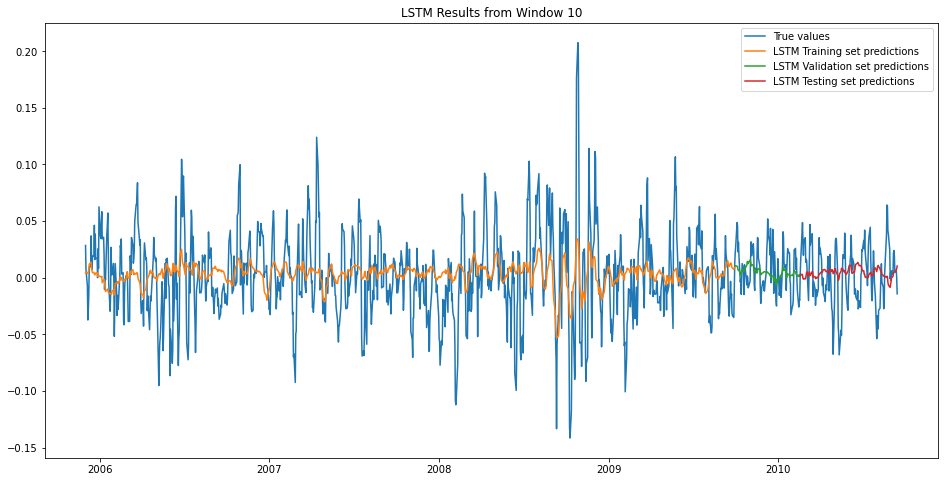

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.00023242953429551094
RMSE = 0.0152456398453955
MAE = 0.011492871212159379
R-Squared = 0.8257211948648263

Results on Validation set: 
MSE = 0.0007422284482757089
RMSE = 0.027243869921061304
MAE = 0.021013009942156328
R-Squared = 0.05246218441981887

Results on Testing set: 
MSE = 0.0007967113426570974
RMSE = 0.028226075580163414
MAE = 0.022958900230417474
R-Squared = -1.4507234615497273



Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0012935529762622196
RMSE = 0.03596599750128195
MAE = 0.02645457565364436
R-Squared = -0.002904296654341998

Results on Validation set: 
MSE = 0.00040678638084027546
RMSE = 0.0201689459526341
MAE = 0.016502813493058367
R-Squared = -0.033510358411453334

Results on Testing set: 
MSE = 0.0007347878493820411
RMSE = 0.027106970494358847
MAE = 0.021215949654480704
R-Squared = -0.14605050879010073



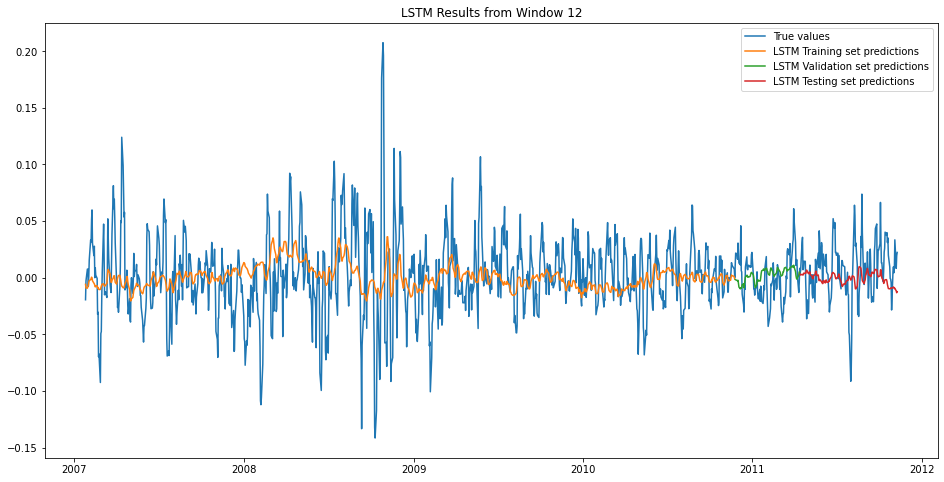

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.000738654931544029
RMSE = 0.027178206922901096
MAE = 0.020193526899549154
R-Squared = 0.3624272111541501

Results on Validation set: 
MSE = 0.0007986046477985817
RMSE = 0.028259593907177465
MAE = 0.020964962235608526
R-Squared = -0.01750558358285459

Results on Testing set: 
MSE = 0.0011568415149268863
RMSE = 0.03401237296818448
MAE = 0.026538330014034852
R-Squared = -0.020757438905084857



Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0010307204678980404
RMSE = 0.03210483558434835
MAE = 0.023686009507435265
R-Squared = 0.08528597162577745

Results on Validation set: 
MSE = 0.0011429102618148435
RMSE = 0.0338069558199913
MAE = 0.025377763296633285
R-Squared = -0.0208092545932701

Results on Testing set: 
MSE = 0.0008508194121805154
RMSE = 0.029168808892042805
MAE = 0.02356861239759191
R-Squared = -0.1227549544683344



Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0006803348654201409
RMSE = 0.026083229581862384
MAE = 0.01923641686709587
R-Squared = 0.2754621366821315

Results on Validation set: 
MSE = 0.0007911804134895402
RMSE = 0.028127929420587294
MAE = 0.0225514720808923
R-Squared = 0.006031596219654101

Results on Testing set: 
MSE = 0.0012258174525075732
RMSE = 0.035011675945426736
MAE = 0.028468160597941328
R-Squared = -0.0063423605587098475



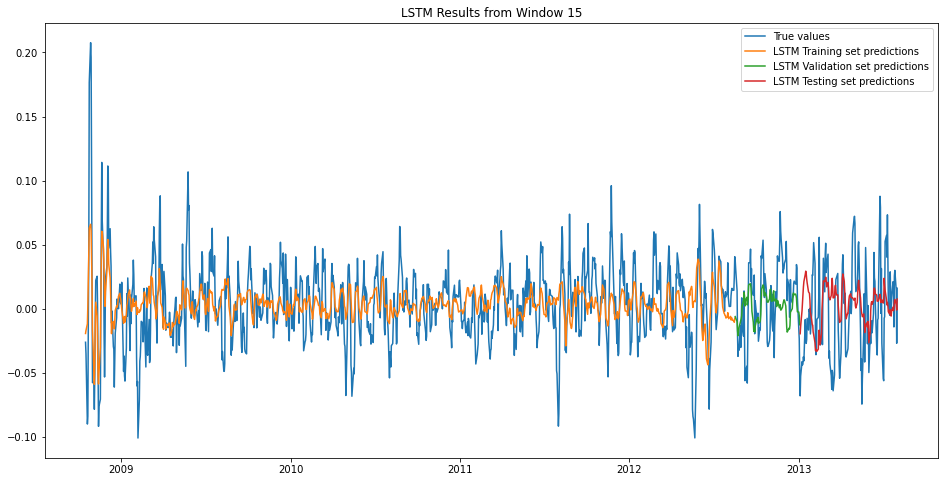

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0005789213471753623
RMSE = 0.024060784425603464
MAE = 0.01839822128852892
R-Squared = 0.1979583178978085

Results on Validation set: 
MSE = 0.001013803799800437
RMSE = 0.031840285799603574
MAE = 0.02630281105246332
R-Squared = 0.18734859448154395

Results on Testing set: 
MSE = 0.0014731929813033586
RMSE = 0.03838219615008186
MAE = 0.030106797071312953
R-Squared = -0.4386699082229386



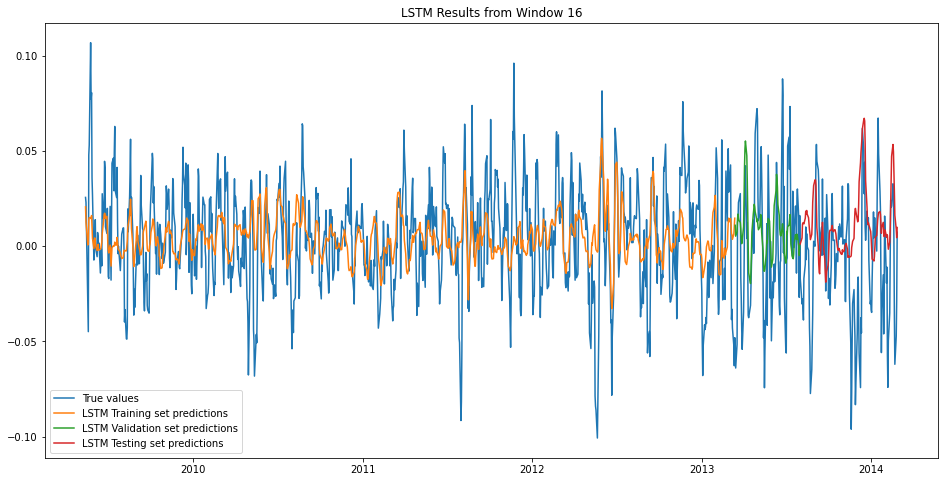

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0007853945583986226
RMSE = 0.028024891764262403
MAE = 0.02203056404666242
R-Squared = 0.006781300287352465

Results on Validation set: 
MSE = 0.0012592900911292766
RMSE = 0.03548647758131647
MAE = 0.027228135185435976
R-Squared = -0.11429023300829644

Results on Testing set: 
MSE = 0.0007111761447095813
RMSE = 0.026667886018760117
MAE = 0.019807610829852114
R-Squared = -0.060061033777281114



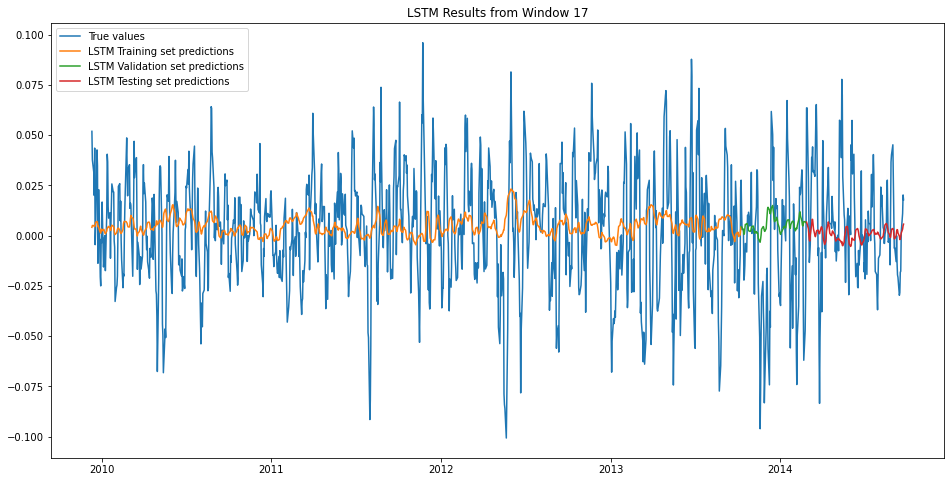

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0004653060332000567
RMSE = 0.021570953460615893
MAE = 0.01619204070581727
R-Squared = 0.46540608321481525

Results on Validation set: 
MSE = 0.0005131048620780843
RMSE = 0.02265181807445231
MAE = 0.017113724012068364
R-Squared = 0.06875995640385046

Results on Testing set: 
MSE = 0.0031391107274527986
RMSE = 0.056027767468040335
MAE = 0.044804464214298886
R-Squared = -0.816304592760164



Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0009153862490984324
RMSE = 0.03025535075153538
MAE = 0.0235135428410667
R-Squared = 0.025311522773737383

Results on Validation set: 
MSE = 0.0021095718913791413
RMSE = 0.04593007610900662
MAE = 0.03480596590027798
R-Squared = -0.15621559436866095

Results on Testing set: 
MSE = 0.0012535949706868534
RMSE = 0.03540614312074747
MAE = 0.027420982362213676
R-Squared = -0.14412464307936346



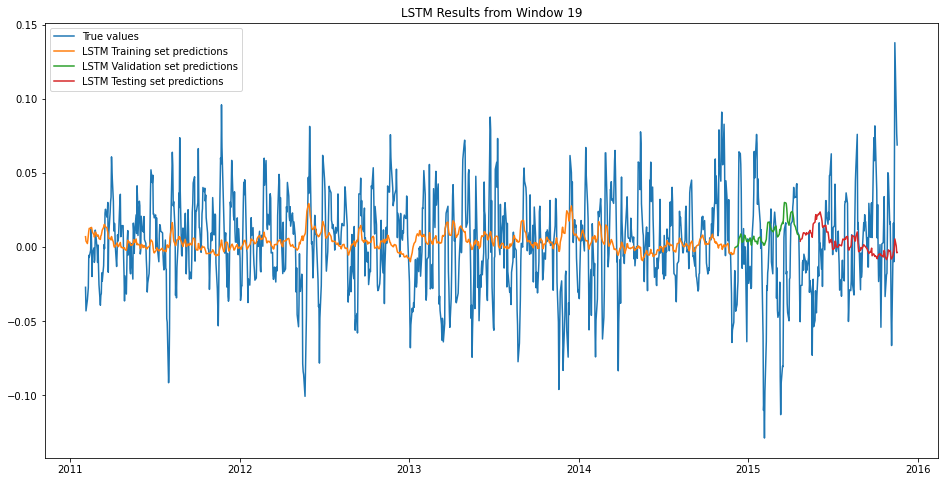

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.001036300174145777
RMSE = 0.032191616519612325
MAE = 0.02504096023637857
R-Squared = 0.033865916811264385

Results on Validation set: 
MSE = 0.0011758992471496527
RMSE = 0.03429138736110939
MAE = 0.025831993980247
R-Squared = -0.003989122502528808

Results on Testing set: 
MSE = 0.001685943094351479
RMSE = 0.041060237387909475
MAE = 0.03383495792729559
R-Squared = -0.050819637900325176



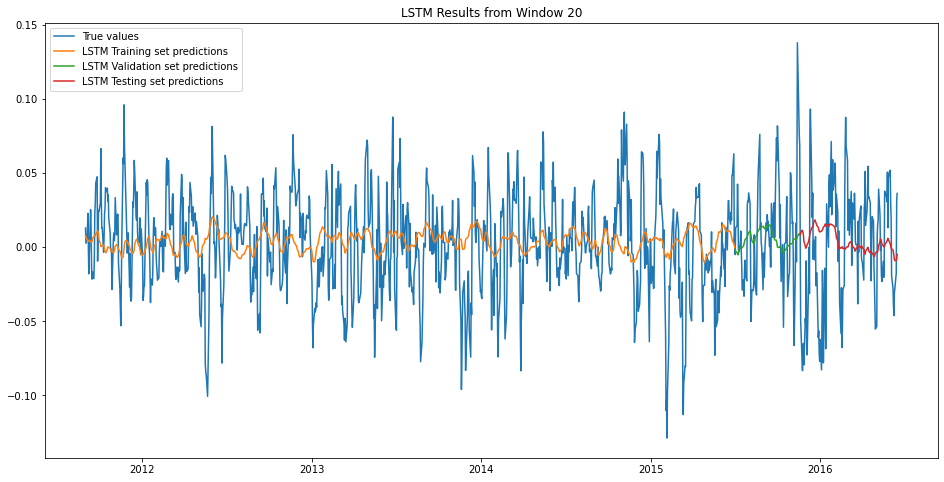

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.001194592361139519
RMSE = 0.034562875475566544
MAE = 0.026774291082685822
R-Squared = 0.010739517117997033

Results on Validation set: 
MSE = 0.001042842887367134
RMSE = 0.0322930780101113
MAE = 0.02747425878502322
R-Squared = 0.0009487371853608151

Results on Testing set: 
MSE = 0.0008302421485124911
RMSE = 0.028813922824087856
MAE = 0.02349527019975621
R-Squared = -0.03157556173758236



Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0007300149410008078
RMSE = 0.027018788666422627
MAE = 0.020369943598306066
R-Squared = 0.3888619462997168

Results on Validation set: 
MSE = 0.0008924643784810645
RMSE = 0.029874142305362752
MAE = 0.02376431872306102
R-Squared = 0.008116641756215182

Results on Testing set: 
MSE = 0.0007877931356443501
RMSE = 0.02806765283461284
MAE = 0.02252281672346261
R-Squared = -0.3282089701051647



Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.001121511821033764
RMSE = 0.03348898059114019
MAE = 0.02582935532014915
R-Squared = 0.018113702712217683

Results on Validation set: 
MSE = 0.0005610625957795652
RMSE = 0.02368675992573837
MAE = 0.01884138439310378
R-Squared = 0.01825145878247203

Results on Testing set: 
MSE = 0.001694393007822708
RMSE = 0.04116300533030488
MAE = 0.028014884285716846
R-Squared = 0.006919015993282596



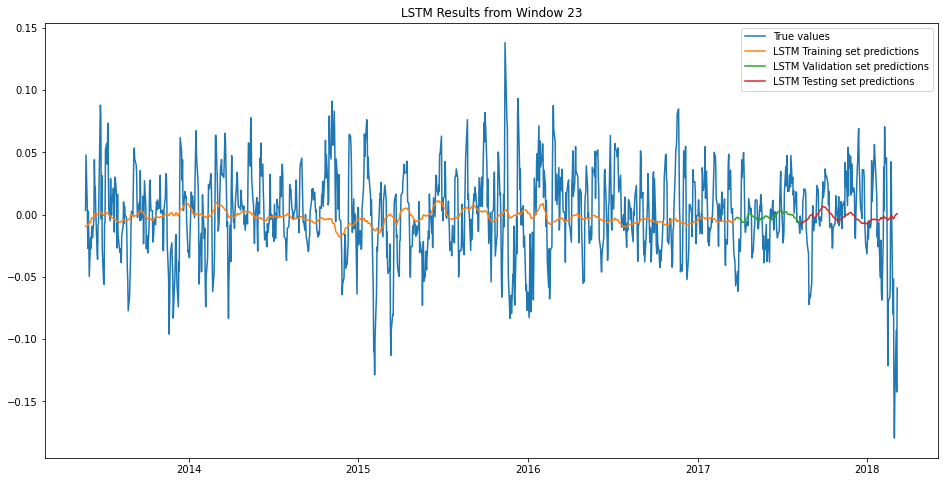

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0005428942947549983
RMSE = 0.023300092161942156
MAE = 0.01767283708774368
R-Squared = 0.4908389626170915

Results on Validation set: 
MSE = 0.0021629740540388223
RMSE = 0.04650778487564015
MAE = 0.03145159607162764
R-Squared = 0.025129988364110067

Results on Testing set: 
MSE = 0.0032023477648176497
RMSE = 0.05658929019538635
MAE = 0.03888641906291463
R-Squared = -0.6748976878230106



Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4849

Results on Training set: 
MSE = 0.0012058619611037714
RMSE = 0.03472552319409704
MAE = 0.02642139675433902
R-Squared = -6.605835404438487e-05

Results on Validation set: 
MSE = 0.0028088510464738497
RMSE = 0.05299859475942593
MAE = 0.03529973738773285
R-Squared = -0.21331664248700566

Results on Testing set: 
MSE = 0.0016516028593154656
RMSE = 0.040639917068265106
MAE = 0.032480979498832975
R-Squared = -0.3581263838986477



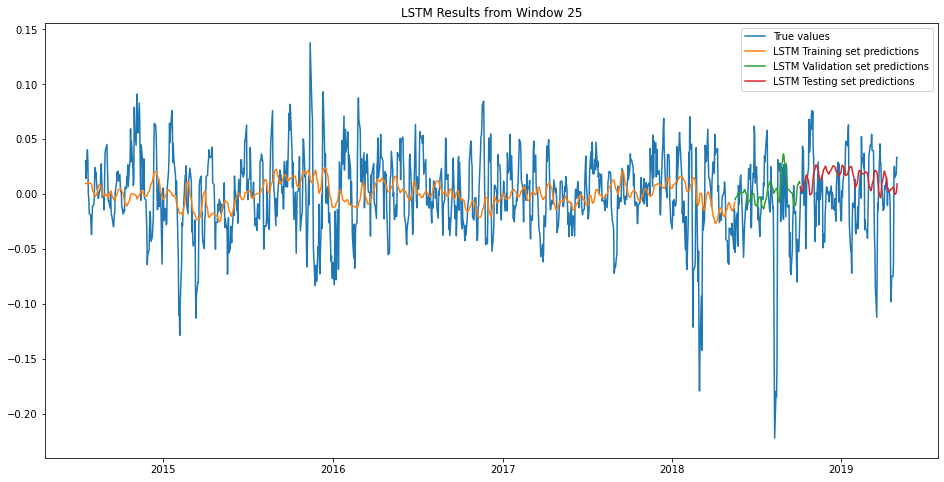

Window 26: 
Training datapoints: 3750 - 4749
Validation datapoints: 4750 - 4849
Testing datapoints: 4850 - 5018

Results on Training set: 
MSE = 0.0013670098139086
RMSE = 0.03697309581180078
MAE = 0.027318433294393856
R-Squared = -0.04517620726159355

Results on Validation set: 
MSE = 0.0011395741984597432
RMSE = 0.03375757986674612
MAE = 0.026380688573582618
R-Squared = 0.13370174095407505

Results on Testing set: 
MSE = 0.0016916522949427804
RMSE = 0.04112970088564687
MAE = 0.03200320118656612
R-Squared = 0.02967818812249967



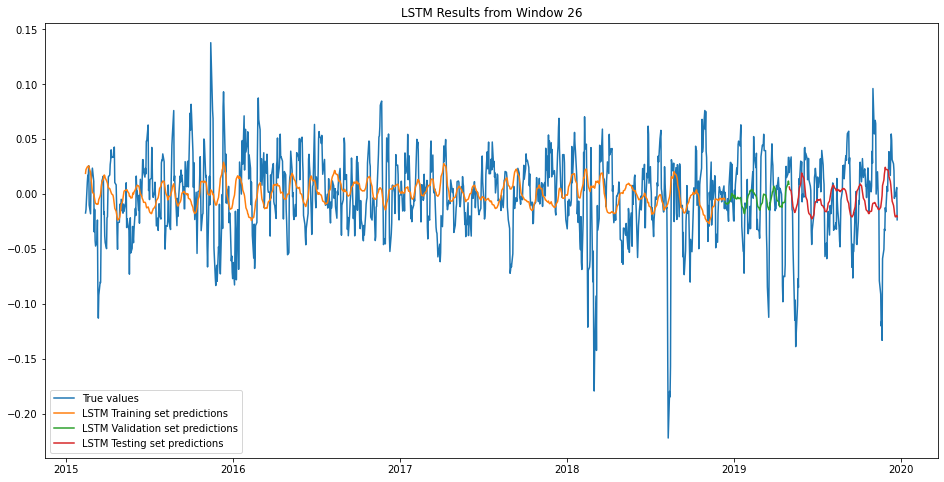

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 100
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.0006277318630327672
  dropout =  0.17310481009819254
  units = 170

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 179
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0007181318794992142
RMSE = 0.02679798275055819
MAE = 0.020585972434066433
R-Squared = 0.11195207113290029

Results on Validation set: 
MSE = 0.0004328686724243123
RMSE = 0.020805496207115855
MAE = 0.016569011771232066
R-Squared = 0.004515543680354672

Results on Testing set: 
MSE = 0.0007261548878944222
RMSE = 0.026947261231791666
MAE = 0.02181427819428845
R-Squared = -0.09802996268394026



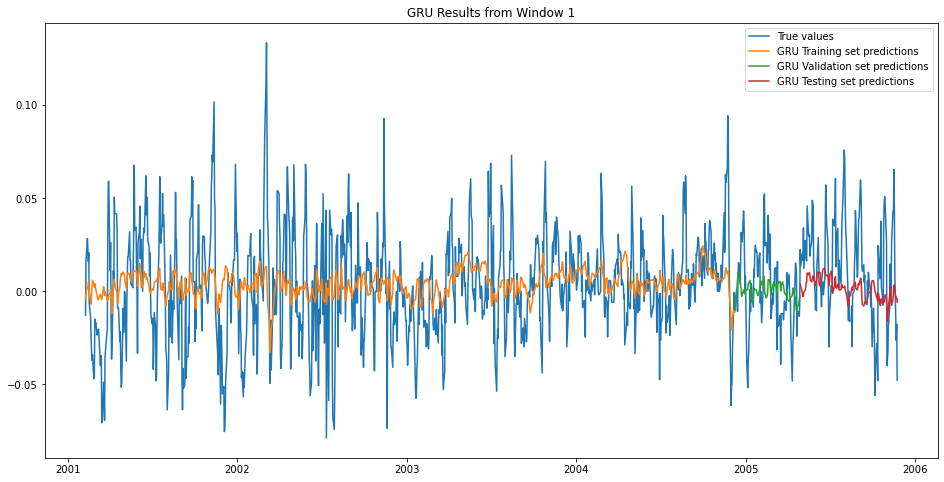

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0007063689071374952
RMSE = 0.02657760160619267
MAE = 0.01990888511876327
R-Squared = 0.01610312600674202

Results on Validation set: 
MSE = 0.0007948674851487518
RMSE = 0.02819339435308831
MAE = 0.0221422213447552
R-Squared = 0.025256106596303618

Results on Testing set: 
MSE = 0.0013504167674340472
RMSE = 0.03674801719051039
MAE = 0.02833777103800277
R-Squared = -0.1139721392224684



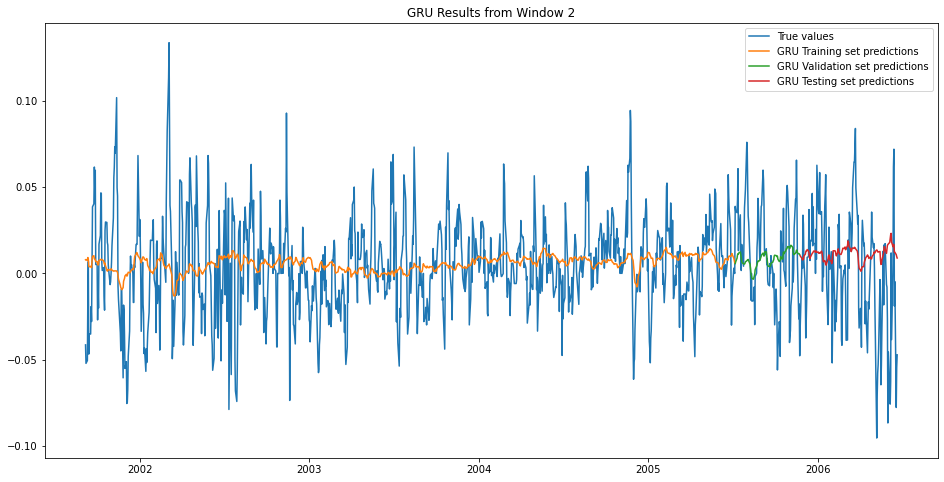

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0006210877350121018
RMSE = 0.02492163186896279
MAE = 0.019072814060516488
R-Squared = 0.01171821373877846

Results on Validation set: 
MSE = 0.0014157674326468394
RMSE = 0.037626685113717355
MAE = 0.0299801890393263
R-Squared = -0.04103415588096082

Results on Testing set: 
MSE = 0.0009913127755567708
RMSE = 0.03148511990697782
MAE = 0.02403921759065872
R-Squared = -0.001641001929023389



Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0006163446566819248
RMSE = 0.02482628962777009
MAE = 0.01881556579109653
R-Squared = 0.1226216792058642

Results on Validation set: 
MSE = 0.0007403498385861508
RMSE = 0.027209370418775785
MAE = 0.02196348862067802
R-Squared = 0.039685154197681705

Results on Testing set: 
MSE = 0.0012330910330090638
RMSE = 0.035115395954040785
MAE = 0.02630915288258872
R-Squared = 0.009027457232077651



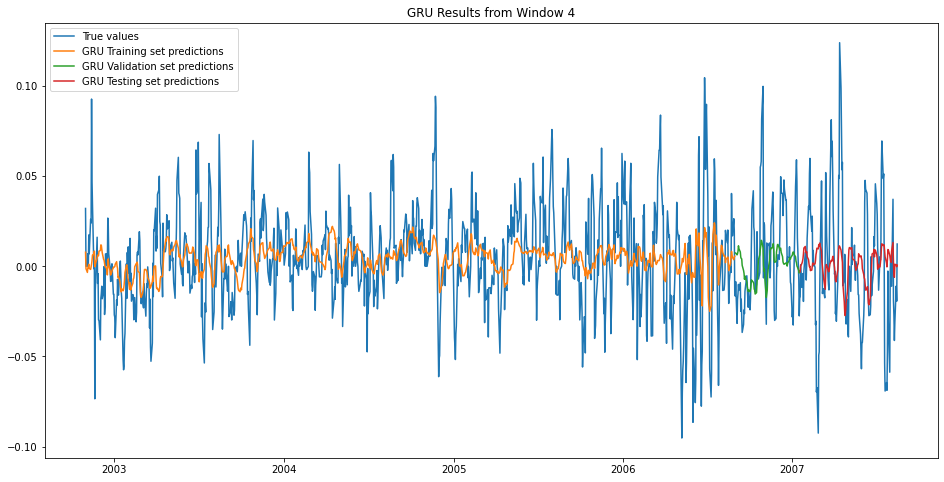

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0006744421891907913
RMSE = 0.02597002482075809
MAE = 0.019595882791169132
R-Squared = 0.09349136418607817

Results on Validation set: 
MSE = 0.0011417229241365932
RMSE = 0.03378939070383769
MAE = 0.025391137285910855
R-Squared = 0.08834023018744841

Results on Testing set: 
MSE = 0.00151946394590417
RMSE = 0.03898030202428106
MAE = 0.028368986374221788
R-Squared = -0.5863207587367036



Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0008019576853062349
RMSE = 0.028318857415267216
MAE = 0.021222045595284393
R-Squared = 0.009291321724198442

Results on Validation set: 
MSE = 0.0017275725590958032
RMSE = 0.04156407774864977
MAE = 0.03130233953948732
R-Squared = -0.5684048481777568

Results on Testing set: 
MSE = 0.0017753271892738168
RMSE = 0.042134631709246216
MAE = 0.0331435708820762
R-Squared = 0.04007790038768555



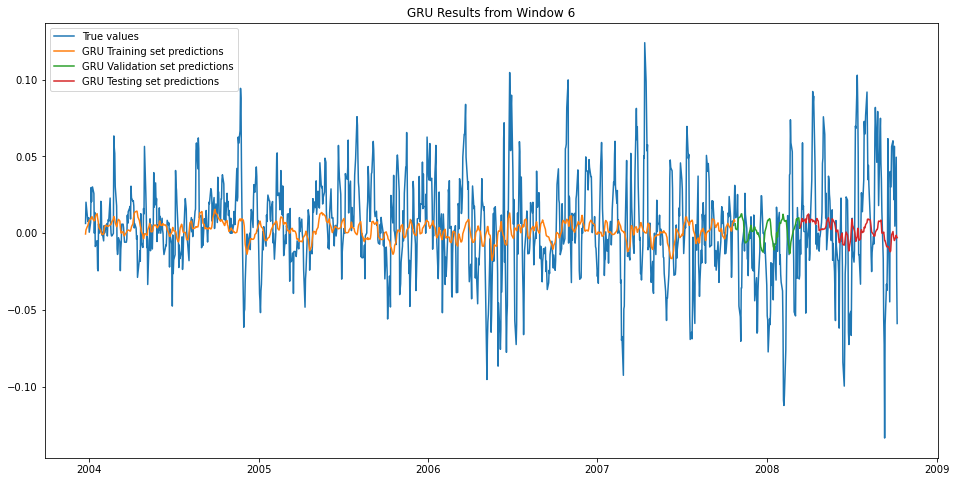

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0008567094713158621
RMSE = 0.02926959978058911
MAE = 0.021926049144980284
R-Squared = 0.12110527761980228

Results on Validation set: 
MSE = 0.0020324387215834108
RMSE = 0.04508257669636254
MAE = 0.03784113493396963
R-Squared = 0.10711362315331463

Results on Testing set: 
MSE = 0.002358185139503076
RMSE = 0.04856114845741476
MAE = 0.03572255621215872
R-Squared = 0.13389676702460618



Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.001377914266365039
RMSE = 0.037120267595547304
MAE = 0.02781553875769193
R-Squared = 0.025436113054223664

Results on Validation set: 
MSE = 0.0009564392786543779
RMSE = 0.030926352495151733
MAE = 0.024461629712535606
R-Squared = 0.021009791582445314

Results on Testing set: 
MSE = 0.0006762503337853538
RMSE = 0.0260048136656534
MAE = 0.019597117879803456
R-Squared = -0.01663359388343677



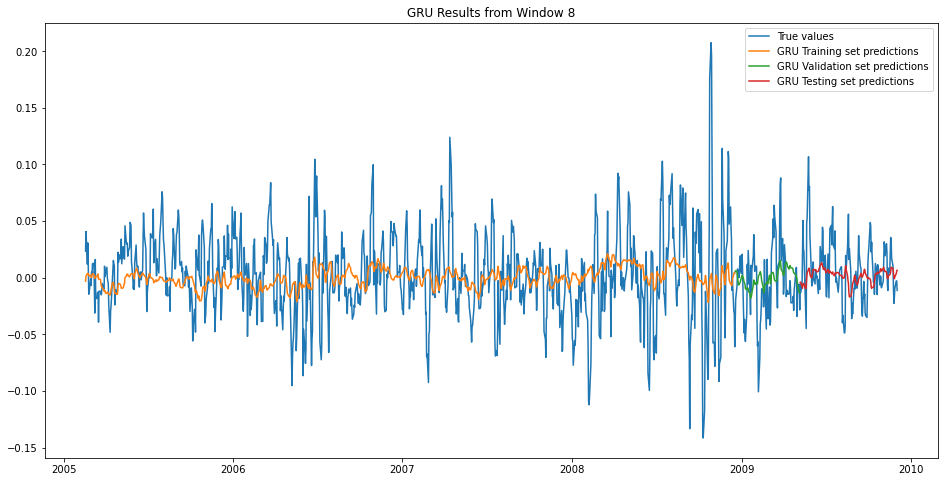

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0014192779708705396
RMSE = 0.03767330581287684
MAE = 0.028454112823495574
R-Squared = 0.039208119035284206

Results on Validation set: 
MSE = 0.0004976504868163902
RMSE = 0.02230808119978924
MAE = 0.01777604625304878
R-Squared = 0.050347923831854935

Results on Testing set: 
MSE = 0.0006306001189019153
RMSE = 0.02511175260514318
MAE = 0.020594361767435766
R-Squared = -0.03497384696813621



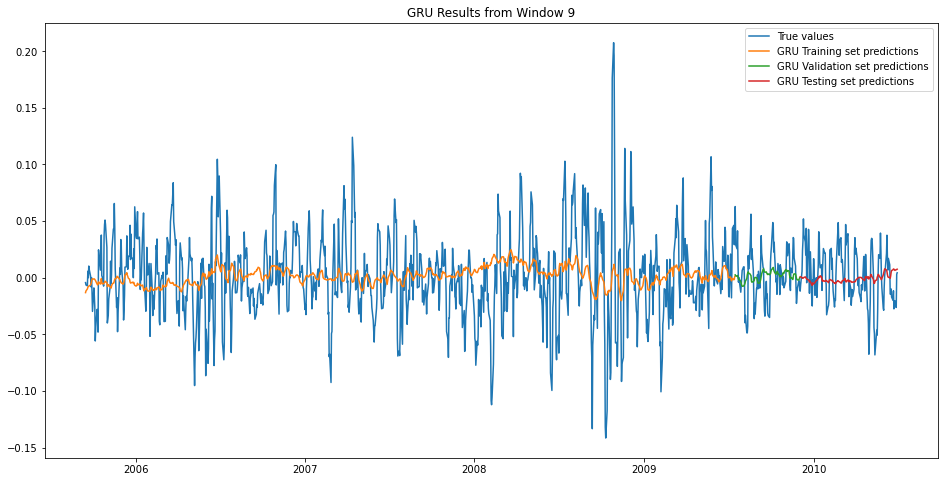

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0012569132506239447
RMSE = 0.03545297238066147
MAE = 0.0263633504525965
R-Squared = 0.11616249297389136

Results on Validation set: 
MSE = 0.0006308298946086552
RMSE = 0.025116327251583883
MAE = 0.020081425739996973
R-Squared = 0.04779646216485589

Results on Testing set: 
MSE = 0.0005026605469067719
RMSE = 0.022420092482119066
MAE = 0.017248264022289676
R-Squared = -0.2888792944881251



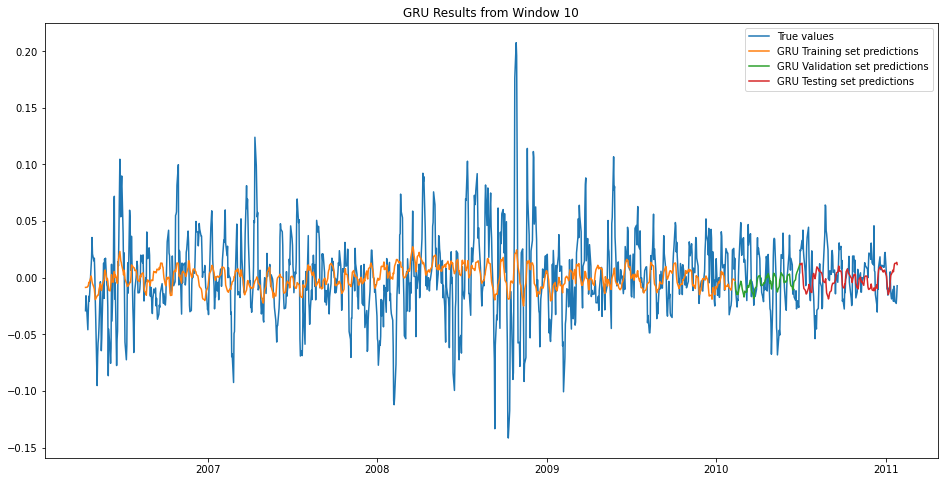

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0010938184375333152
RMSE = 0.0330729260503711
MAE = 0.02441833097382998
R-Squared = 0.1690417839211884

Results on Validation set: 
MSE = 0.0002444912764933702
RMSE = 0.015636216821641038
MAE = 0.012250601528382943
R-Squared = -0.10093239653088104

Results on Testing set: 
MSE = 0.0007118001497045308
RMSE = 0.026679583012193628
MAE = 0.020536170484243717
R-Squared = -0.12449101480271918



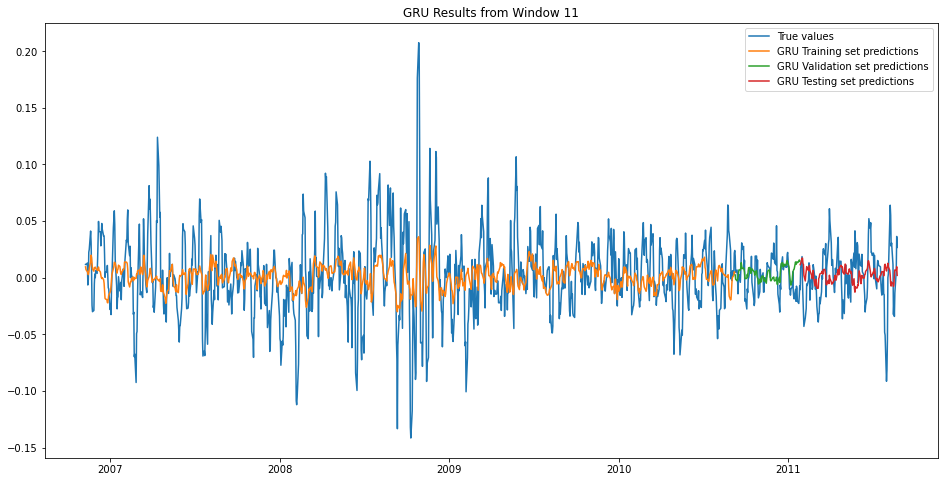

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.001409182781849532
RMSE = 0.03753908339117422
MAE = 0.028386158504871306
R-Squared = -0.17393280582528314

Results on Validation set: 
MSE = 0.0007365176027576327
RMSE = 0.027138857801271458
MAE = 0.019999445722598073
R-Squared = -0.08480271917132676

Results on Testing set: 
MSE = 0.0006664657522015967
RMSE = 0.025815997989649685
MAE = 0.02132537674130082
R-Squared = 0.0765639845546



Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0009509060803273181
RMSE = 0.030836765075593096
MAE = 0.022707442587792656
R-Squared = 0.19400328171003955

Results on Validation set: 
MSE = 0.0007748581389348734
RMSE = 0.027836273797598583
MAE = 0.02253284006739952
R-Squared = 0.06320913412004914

Results on Testing set: 
MSE = 0.0010776635910520213
RMSE = 0.0328277868741105
MAE = 0.023572543401142544
R-Squared = -0.006068725400252051



Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0009542860981854053
RMSE = 0.030891521461161562
MAE = 0.022732782805151956
R-Squared = 0.1120602154672301

Results on Validation set: 
MSE = 0.0007035976336370261
RMSE = 0.02652541486267512
MAE = 0.020643832315443665
R-Squared = 0.14571510615284078

Results on Testing set: 
MSE = 0.0012164354720659667
RMSE = 0.03487743499837634
MAE = 0.0299476380873971
R-Squared = -0.11709508235704424



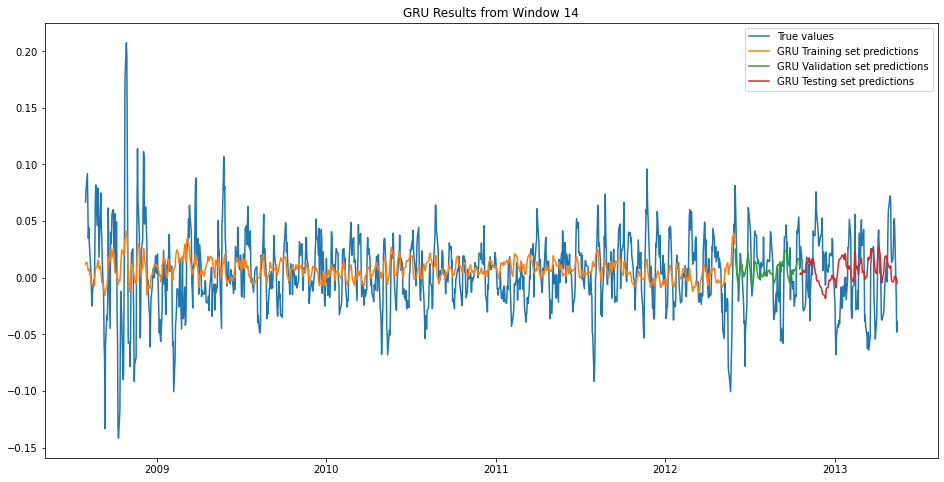

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0006915821194084392
RMSE = 0.026297948958206592
MAE = 0.020659775257329024
R-Squared = 0.021778315333393805

Results on Validation set: 
MSE = 0.001135829528287678
RMSE = 0.03370207008905652
MAE = 0.02827686473316706
R-Squared = 0.0584901928852658

Results on Testing set: 
MSE = 0.0011035664106340763
RMSE = 0.03321997005769386
MAE = 0.025651992349973368
R-Squared = -0.018166508611614507



Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0007534144528885765
RMSE = 0.027448396180625497
MAE = 0.02157464670693771
R-Squared = 0.015620000159547232

Results on Validation set: 
MSE = 0.0010651858275684488
RMSE = 0.03263718473717439
MAE = 0.02484225760092787
R-Squared = -0.1200683636336688

Results on Testing set: 
MSE = 0.001054047905566321
RMSE = 0.03246610394806129
MAE = 0.024689505303583114
R-Squared = -0.12317036576858631



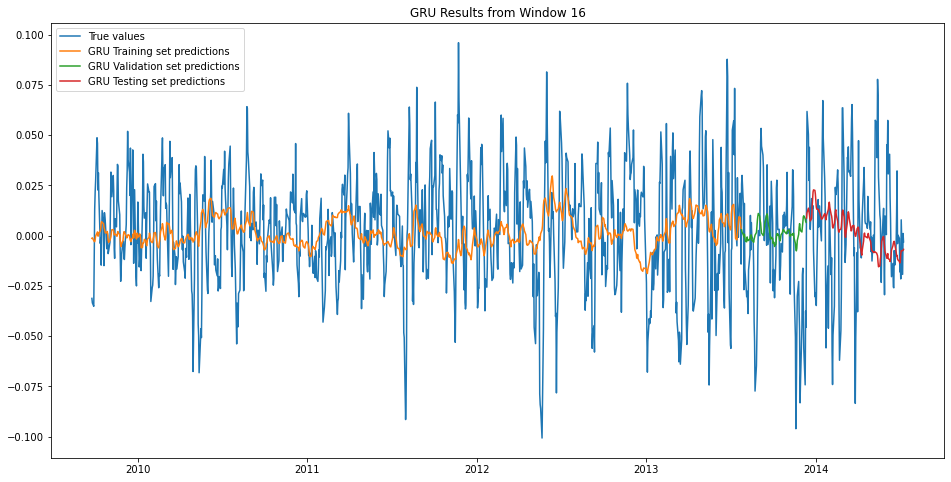

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0008331681008475789
RMSE = 0.028864651406999165
MAE = 0.022480415920030316
R-Squared = 0.0328471525113343

Results on Validation set: 
MSE = 0.0009230057408010337
RMSE = 0.030381009542163565
MAE = 0.02272983669785495
R-Squared = -0.02863660235838017

Results on Testing set: 
MSE = 0.0012402656787325102
RMSE = 0.0352174059057806
MAE = 0.026106194948465344
R-Squared = -0.12102672208516174



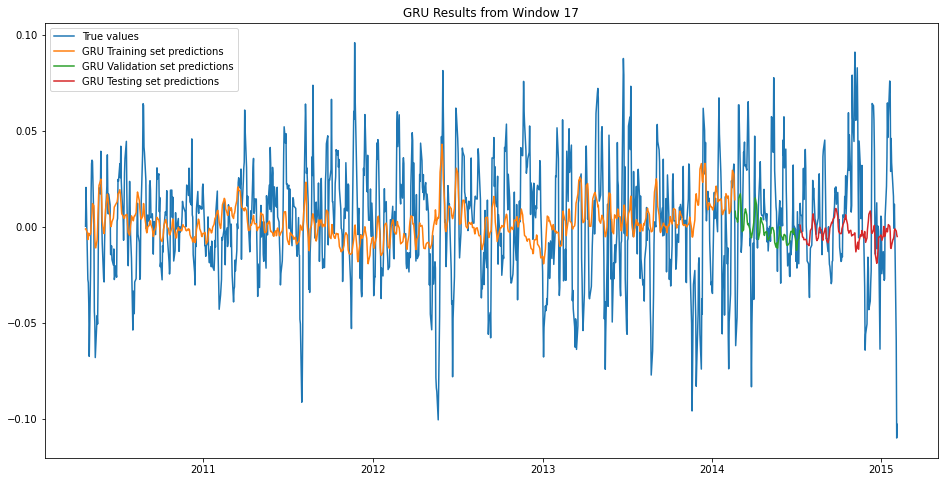

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0008583388126468237
RMSE = 0.029297419897438472
MAE = 0.02269446353650327
R-Squared = 0.02846945787546462

Results on Validation set: 
MSE = 0.0015211125481543273
RMSE = 0.03900144289836374
MAE = 0.029478381278776836
R-Squared = -0.052700961050483164

Results on Testing set: 
MSE = 0.0015374622439444686
RMSE = 0.03921048640280389
MAE = 0.030799854386564664
R-Squared = -0.3532026319261805



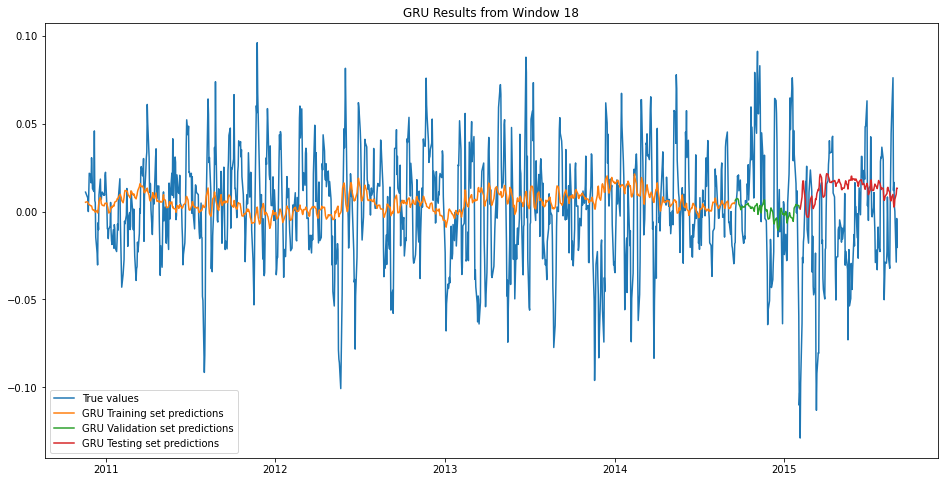

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0010761628993647796
RMSE = 0.0328049218771327
MAE = 0.025515570407217223
R-Squared = 0.01017599777434075

Results on Validation set: 
MSE = 0.0008968082898261249
RMSE = 0.029946757584521984
MAE = 0.024815720379360685
R-Squared = -0.1915654794669357

Results on Testing set: 
MSE = 0.0019602558488826098
RMSE = 0.044274776666659875
MAE = 0.03549379076487219
R-Squared = -0.05256075182082287



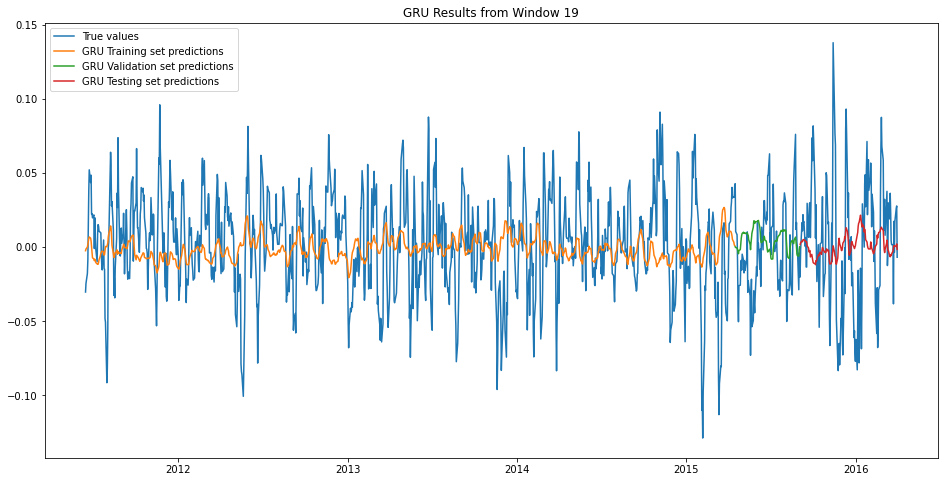

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0011883856889219593
RMSE = 0.03447297041048188
MAE = 0.026668353186070234
R-Squared = -0.10472692587224741

Results on Validation set: 
MSE = 0.0022654144273128287
RMSE = 0.0475963698963779
MAE = 0.03875095126537668
R-Squared = 0.00882696322630605

Results on Testing set: 
MSE = 0.0010090230658539971
RMSE = 0.03176512341946741
MAE = 0.026056848396537546
R-Squared = -0.32452652117521996



Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0010690031664943045
RMSE = 0.032695613872418795
MAE = 0.025640406421855264
R-Squared = 0.10975678813930556

Results on Validation set: 
MSE = 0.0006782161515867042
RMSE = 0.0260425834276614
MAE = 0.020523678509979985
R-Squared = 0.013443566085952319

Results on Testing set: 
MSE = 0.0009072864755352431
RMSE = 0.030121196449265475
MAE = 0.023342066983899408
R-Squared = -0.12556536776972993



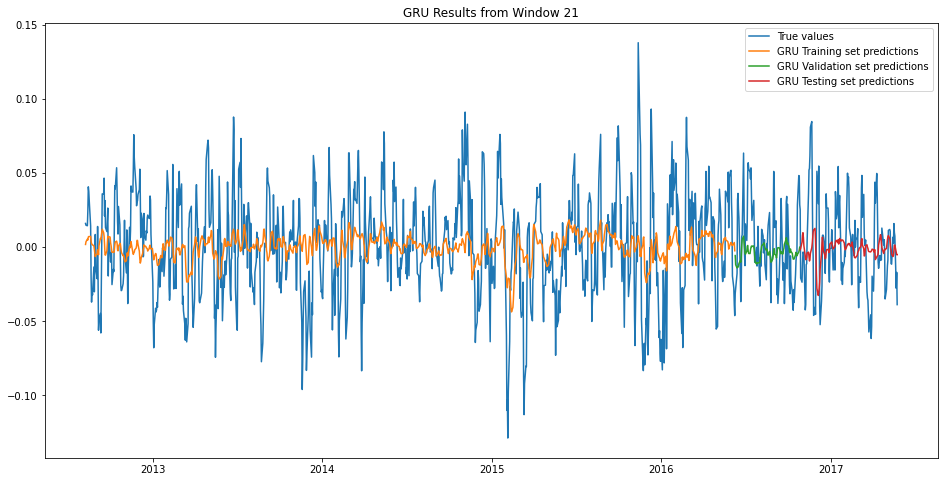

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0008981774125126371
RMSE = 0.02996960814746561
MAE = 0.0228146444854835
R-Squared = 0.24731093084549127

Results on Validation set: 
MSE = 0.0005760521882047955
RMSE = 0.024001087229640148
MAE = 0.01820083571626026
R-Squared = 0.12152482581211188

Results on Testing set: 
MSE = 0.0007786381175986173
RMSE = 0.027904087829538834
MAE = 0.021098312976707875
R-Squared = -0.30904423762373723



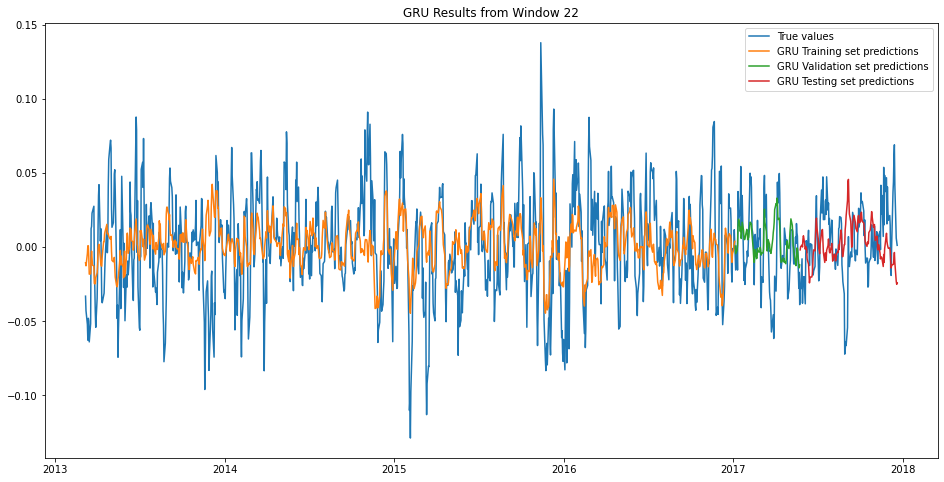

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0010059324998643688
RMSE = 0.03171643895307871
MAE = 0.024445953670031922
R-Squared = 0.09109451096661925

Results on Validation set: 
MSE = 0.0006967706239559438
RMSE = 0.026396413088825985
MAE = 0.01871112724276025
R-Squared = -0.06914731087530646

Results on Testing set: 
MSE = 0.001871779884363596
RMSE = 0.043264071518566025
MAE = 0.03212646659112583
R-Squared = -0.09355384907645692



Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0010495945863606185
RMSE = 0.03239744721981376
MAE = 0.024760666108668134
R-Squared = 0.050893966036162586

Results on Validation set: 
MSE = 0.001708544736122492
RMSE = 0.041334546521311834
MAE = 0.02931010224832364
R-Squared = -0.0989030669465798

Results on Testing set: 
MSE = 0.0022579127270129745
RMSE = 0.04751749916623322
MAE = 0.0318385352445422
R-Squared = -0.09010889387804855



Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4923

Results on Training set: 
MSE = 0.001236725112488101
RMSE = 0.035167102702498836
MAE = 0.025688706543302076
R-Squared = 0.09447882563142518

Results on Validation set: 
MSE = 0.0010615901210511956
RMSE = 0.03258205213075437
MAE = 0.025062355812657974
R-Squared = -0.021639011781773965

Results on Testing set: 
MSE = 0.001605625203742536
RMSE = 0.04007025335261229
MAE = 0.030096242871238365
R-Squared = 0.06596913544755534



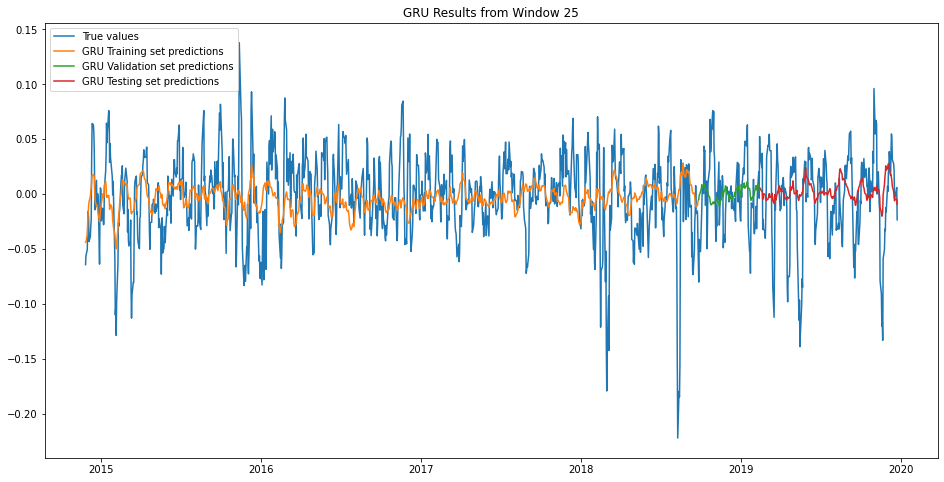

In [10]:
#Declaring model parameters
sequencelength = 195
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.0014058719289736675
RMSE = 0.03749495871412139
MAE = 0.028126341182568165
R-Squared = -0.1961333735580375

GRU model results on the Testing set
MSE = 0.0012377274986495866
RMSE = 0.03518135157508288
MAE = 0.02638745931713896
R-Squared = -0.03726516510989675

Naive model results on the Testing set
MSE = 0.0024833950533726733
RMSE = 0.04983367388997798
MAE = 0.03766010876892873
R-Squared = -1.1129034884682132

Drift model results on the Testing set
MSE = 0.0031335429749794054
RMSE = 0.05597805797792029
MAE = 0.04158208495991888
R-Squared = -1.666057449904037



In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

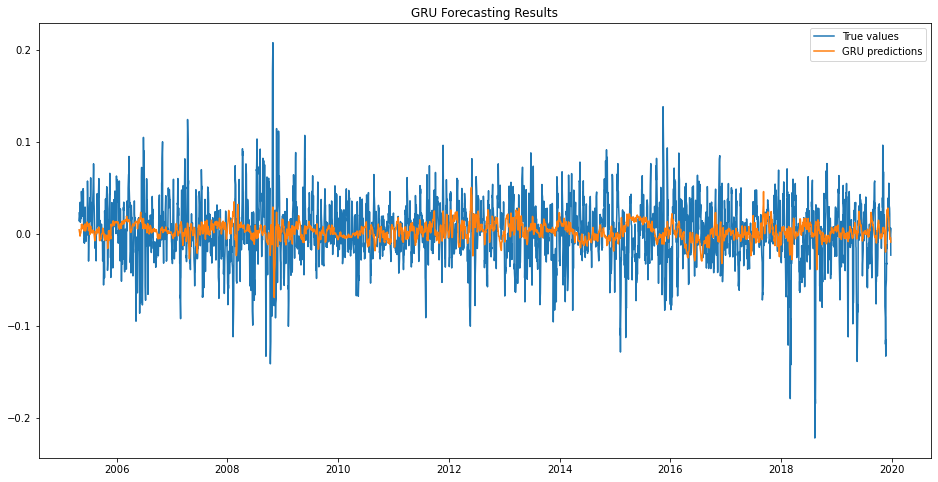

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

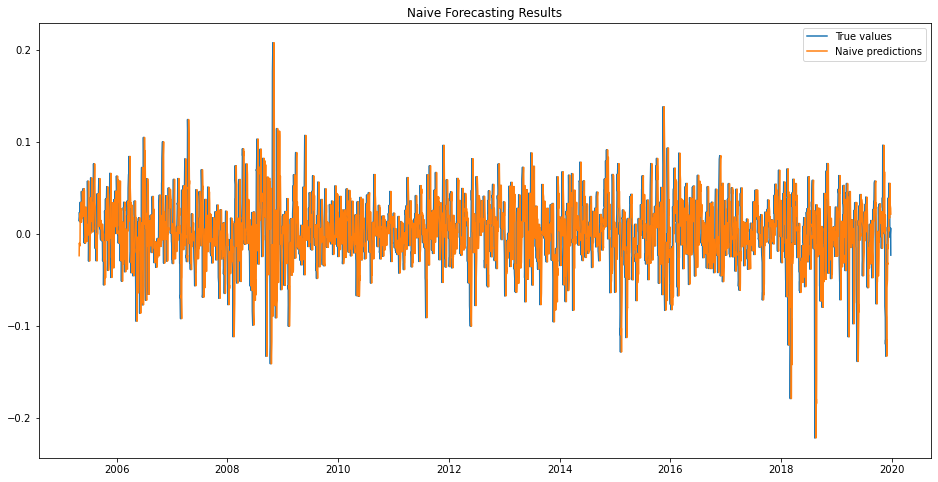

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

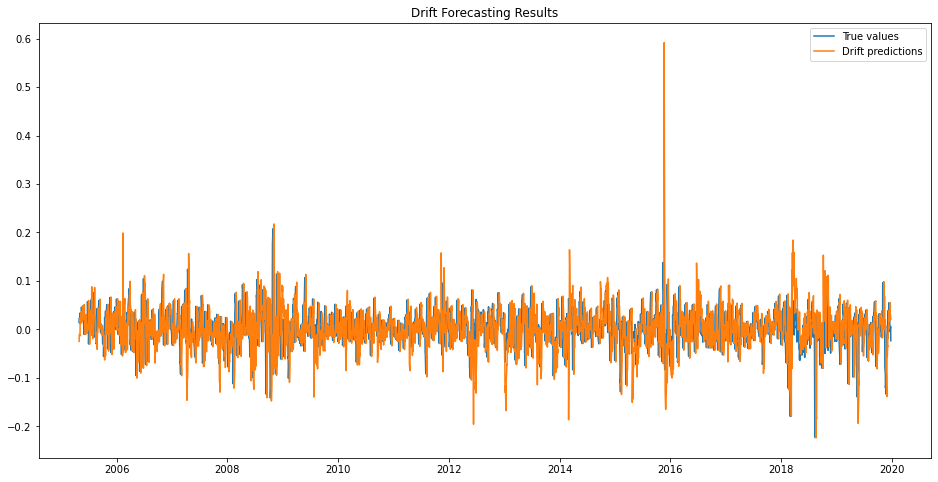

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['TBS LSTM'] = lstm_predictions[-numpreds:]
savePredictions['TBS GRU'] = gru_predictions[-numpreds:]
savePredictions['TBS Naive'] = naive_predictions[-numpreds:]
savePredictions['TBS Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./TBS_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

TBS LSTM   TBS GRU  TBS Naive  TBS Drift
Date                                                
2005-04-28 -0.002376  0.004141  -0.024047  -0.024808
2005-04-29 -0.008708  0.002889  -0.010417  -0.010459
2005-05-02 -0.012156  0.000111  -0.012073  -0.012201
2005-05-03 -0.014608 -0.002107  -0.013451  -0.013647
2005-05-04 -0.016335 -0.002767  -0.007427  -0.007318